In [1]:
import pandas as pd
import numpy as np
import requests
from lxml import etree
import re
from scipy import stats
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats import diagnostic
import mplcursors

In [2]:
pd.options.display.precision = 2
pd.options.display.max_rows = 100
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
BLUE = '#1f77b4'
ORANGE = '#ff7f0e'

Ttest_indResult(statistic=array([-0.34433211,  1.18352139]), pvalue=array([0.73458666, 0.25199801]))

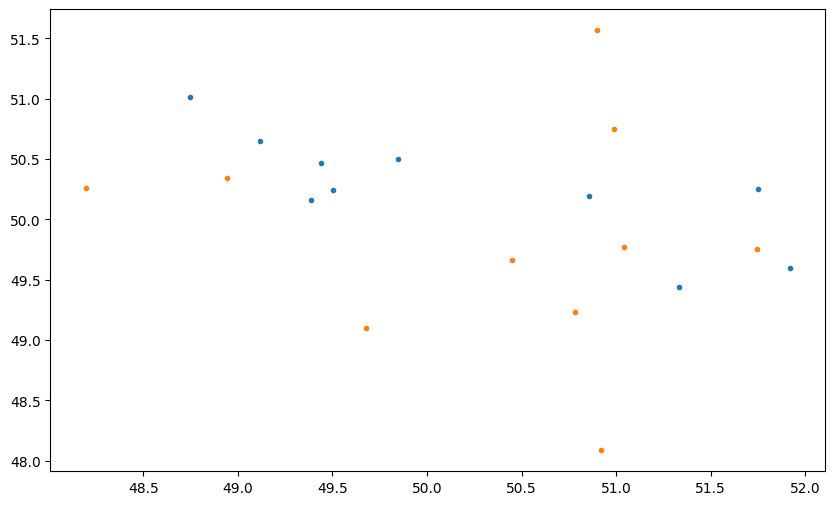

In [4]:
first = stats.multivariate_normal(mean=[50, 50]).rvs(size=10, random_state=None)
second = stats.multivariate_normal(mean=[50.1, 49.9]).rvs(size=10, random_state=None)

plt.plot(*first.T, '.')
plt.plot(*second.T, '.')

stats.ttest_ind(first, second)

In [5]:
DIMENSIONS = ['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr']

# https://geerthofstede.com/research-and-vsm/dimension-data-matrix/
cul_dim_df = (pd.read_csv('./data/6-dimensions-for-website-2015-08-16.csv', sep=';')
    .replace('#NULL!', np.nan)
    .astype({dim: float for dim in DIMENSIONS})
)

cul_dim_df.info()
cul_dim_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ctr      111 non-null    object 
 1   country  111 non-null    object 
 2   pdi      78 non-null     float64
 3   idv      78 non-null     float64
 4   mas      78 non-null     float64
 5   uai      78 non-null     float64
 6   ltowvs   96 non-null     float64
 7   ivr      97 non-null     float64
dtypes: float64(6), object(2)
memory usage: 7.1+ KB


,ctr,country,pdi,idv,mas,uai,ltowvs,ivr
0,AFE,Africa East,64.0,27.0,41.0,52.0,32.0,40.0
1,AFW,Africa West,77.0,20.0,46.0,54.0,9.0,78.0
2,ALB,Albania,NaN,NaN,NaN,NaN,61.0,15.0
3,ALG,Algeria,NaN,NaN,NaN,NaN,26.0,32.0
4,AND,Andorra,NaN,NaN,NaN,NaN,NaN,65.0
...,...,...,...,...,...,...,...,...
106,URU,Uruguay,61.0,36.0,38.0,100.0,26.0,53.0
107,VEN,Venezuela,81.0,12.0,73.0,76.0,16.0,100.0
108,VIE,Vietnam,70.0,20.0,40.0,30.0,57.0,35.0
109,ZAM,Zambia,NaN,NaN,NaN,NaN,30.0,42.0


In [6]:
cul_dim_df.describe()

,pdi,idv,mas,uai,ltowvs,ivr
count,78.00,78.00,78.00,78.00,96.00,97.00
mean,59.33,45.17,49.27,67.64,45.49,45.39
std,21.22,23.97,19.01,22.99,24.22,22.18
min,11.00,6.00,5.00,8.00,0.00,0.00
25%,42.50,23.50,40.00,51.25,25.75,29.00
50%,62.00,43.50,48.50,69.50,44.50,43.00
75%,72.50,67.75,61.75,86.00,63.25,63.00
max,104.00,91.00,110.00,112.00,100.00,100.00


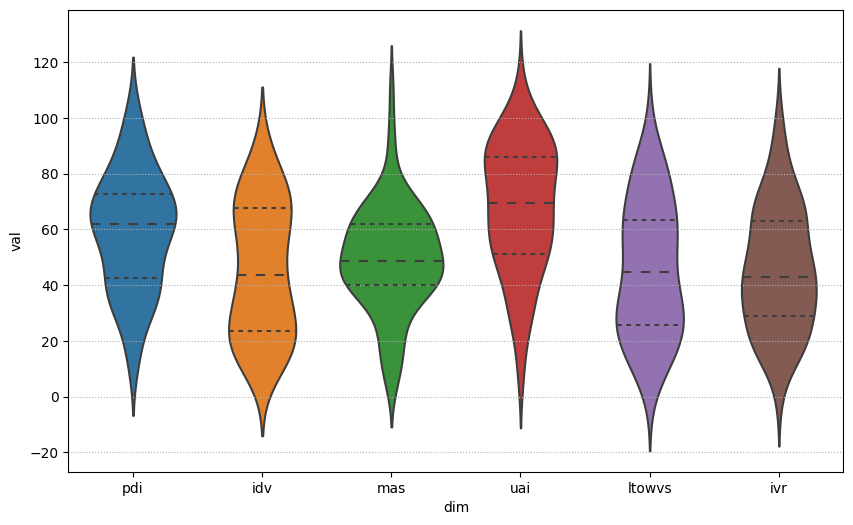

In [7]:
df = cul_dim_df.iloc[:, 2:].stack().reset_index(1).rename({'level_1': 'dim', 0: 'val'}, axis=1)

sns.violinplot(df, x='dim', y='val', inner='quartile')
plt.grid(axis='y', linestyle=':')

In [85]:
normality = pd.DataFrame([
    {
        'dim': key,
        'ks_test': diagnostic.kstest_normal(frame.val.values)[1],
        'ad_test': diagnostic.normal_ad(frame.val.values)[1],
    } for key, frame in df.groupby('dim')
]).set_index('dim')

display(normality)
display(normality > 0.05)

print(normality.to_markdown())

,ks_test,ad_test
dim,,
idv,0.04,5.92e-04
ivr,0.50,1.30e-01
ltowvs,0.02,9.60e-03
mas,0.27,1.59e-01
pdi,0.55,5.04e-01
uai,0.04,4.96e-02


,ks_test,ad_test
dim,,
idv,False,False
ivr,True,True
ltowvs,False,False
mas,True,True
pdi,True,True
uai,False,False


| dim    |   ks_test |     ad_test |
|:-------|----------:|------------:|
| idv    | 0.0357113 | 0.000591842 |
| ivr    | 0.495077  | 0.13018     |
| ltowvs | 0.0215968 | 0.00959888  |
| mas    | 0.268814  | 0.15928     |
| pdi    | 0.548837  | 0.503694    |
| uai    | 0.0384659 | 0.0495701   |


In [9]:
# Missing values
# na_bools = cul_dim_df.isna().any(axis=1)
# cul_dim_df = cul_dim_df[~ na_bools]
# cul_dim_df

In [10]:
resp = requests.request('get', 'https://www.cia.gov/the-world-factbook/about/archives/2021/field/languages/')

root = etree.HTML(resp.text)
html = etree.tostring(root, pretty_print=True, method="html")

country_and_languages = []

countries = root.xpath('/html/body/div/div[1]/div[2]/main/div/section/div/div/div/ul/li')
for country in countries:
    name = country.xpath('./h2/a/text()')[0]
    languages = country.xpath('./p/text()')[0]
    country_and_languages.append((name, languages))

languages_df = pd.DataFrame(country_and_languages, columns=['country', 'languages'])
languages_df

,country,languages
0,Afghanistan,"Afghan Persian or Dari (official, lingua franc..."
1,Akrotiri,"English, Greek"
2,Albania,Albanian 98.8% (official - derived from Tosk d...
3,Algeria,"Arabic (official), French (lingua franca), Ber..."
4,American Samoa,Samoan 88.6% (closely related to Hawaiian and ...
...,...,...
235,West Bank,"Arabic, Hebrew (spoken by Israeli settlers and..."
236,World,"English 16.5%, Mandarin Chinese 14.6%, Hindi 8..."
237,Yemen,Arabic (official); note - a distinct Socotri l...
238,Zambia,"Bemba 33.4%, Nyanja 14.7%, Tonga 11.4%, Lozi 5..."


In [11]:
# Complicated processing left for the next time
# combined_str = '\n'.join(languages_df.languages.values)
# # remove = [
# #     ',',
# #     '(',
# #     ')',
# #     'official',
# # ]
# # for character in remove:
# #     combined_str = combined_str.replace(character, '')
# print(combined_str)
# # re.split(r'official|\d+%', combined_str)

In [12]:
languages_df[languages_df.country.str.fullmatch(r'.*keny.*', case=False)].values

array([['Kenya',
        'English (official), Kiswahili (official), numerous indigenous languages']],
      dtype=object)

In [13]:
cul_dim_df[cul_dim_df.country.str.fullmatch(r'.*south.*', case=False)]

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr
58,KOR,Korea South,60.0,18.0,39.0,85.0,100.0,29.0
90,SAF,South Africa,NaN,NaN,NaN,NaN,34.0,63.0
91,SAW,South Africa white,49.0,65.0,63.0,49.0,NaN,NaN


In [14]:
# Merging datasets
countries_cul = set(cul_dim_df['country'])
countries_lan = set(languages_df['country'])
unmatched = countries_cul - countries_lan
print(unmatched)

{'Kyrgyz Rep', 'Great Britain', 'Macedonia Rep', 'Bosnia', 'Belgium French', 'Dominican Rep', 'Czech Rep', 'South Africa white', 'U.S.A.', 'Germany East', 'Canada French', 'Belgium Netherl', 'Switzerland French', 'Africa West', 'Slovak Rep', 'Arab countries', 'Switzerland German', 'Africa East', 'Korea South'}


In [15]:
# Countries name unification
countries_cia = {
    'Great Britain': 'United Kingdom',
    'U.S.A.': 'United States',
    'Czech Rep':'Czechia',
    'Slovak Rep': 'Slovakia',
    'Korea South': 'Korea, South', 
    'Bosnia': 'Bosnia and Herzegovina',
    'Dominican Rep': 'Dominican Republic',
    'Kyrgyz Rep': 'Kyrgyzstan',
    'Macedonia Rep': 'North Macedonia',
}
cul_dim_df = cul_dim_df.assign(country=cul_dim_df['country'].replace(countries_cia))
cul_dim_df

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr
0,AFE,Africa East,64.0,27.0,41.0,52.0,32.0,40.0
1,AFW,Africa West,77.0,20.0,46.0,54.0,9.0,78.0
2,ALB,Albania,NaN,NaN,NaN,NaN,61.0,15.0
3,ALG,Algeria,NaN,NaN,NaN,NaN,26.0,32.0
4,AND,Andorra,NaN,NaN,NaN,NaN,NaN,65.0
...,...,...,...,...,...,...,...,...
106,URU,Uruguay,61.0,36.0,38.0,100.0,26.0,53.0
107,VEN,Venezuela,81.0,12.0,73.0,76.0,16.0,100.0
108,VIE,Vietnam,70.0,20.0,40.0,30.0,57.0,35.0
109,ZAM,Zambia,NaN,NaN,NaN,NaN,30.0,42.0


In [16]:
# print(cul_dim_df.country.values)

pd.merge(cul_dim_df[['country']], languages_df, 'left', on='country').values

array([['Africa East', nan],
       ['Africa West', nan],
       ['Albania',
        'Albanian 98.8% (official - derived from Tosk dialect), Greek 0.5%, other 0.6% (including Macedonian, Romani, Vlach, Turkish, Italian, and Serbo-Croatian), unspecified 0.1% (2011 est.)'],
       ['Algeria',
        'Arabic (official), French (lingua franca), Berber or Tamazight (official); dialects include Kabyle Berber (Taqbaylit), Shawiya Berber (Tacawit), Mzab Berber, Tuareg Berber (Tamahaq)'],
       ['Andorra', 'Catalan (official), French, Castilian, Portuguese'],
       ['Arab countries', nan],
       ['Argentina',
        'Spanish (official), Italian, English, German, French, indigenous (Mapudungun, Quechua)'],
       ['Armenia',
        'Armenian (official) 97.9%, Kurdish (spoken by Yezidi minority) 1%, other 1%; note - Russian is widely spoken (2011 est.)'],
       ['Australia',
        'English 72.7%, Mandarin 2.5%, Arabic 1.4%, Cantonese 1.2%, Vietnamese 1.2%, Italian 1.2%, Greek 1%, other 1

In [17]:
# Germanic
# Romance
# African
# Semitic
# Balto-Slavic
# Uralic
# Turkic
# Indo-Iranian
# Mongolic languages
# Sino-Tibetan
# Japonic languages
# Koreanic languages
# Malayo-Polynesian

In [87]:
lists = [
    ['Africa East', 'Niger–Congo', 'African'], #Ethiopia, Kenya, Tanzanya, Zambia
    ['Africa West', 'Niger–Congo', 'African'], # Ghana, Nigeria, Sierra Leone
    ['Albania', 'Albanian', 'Palaeo-Balkan'], #98.8%  
    ['Algeria', 'Arabic', 'Semitic'], # (official), French (lingua franca), Berber or Tamazight (official)'],
    ['Andorra', 'Catalan', 'Romance'],# (official) , French, Castilian, Portuguese'],
    ['Arab countries', 'Arabic', 'Semitic'], # Egypt, Iraq, Kuwait, Lebanon, Libya, Saudi Arabia, United Arab Emirates
    ['Argentina', 'Spanish'], #Italian, English, German, French, indigenous (Mapudungun, Quechua)'],
    # ['Armenia', 'Armenian'], #(official) 97.9%, Kurdish (spoken by Yezidi minority) 1%, other 1%; note - Russian is widely spoken (2011 est.)'],
    ['Australia', 'English'], #72.7%, Mandarin 2.5%, Arabic 1.4%, Cantonese 1.2%, Vietnamese 1.2%, Italian 1.2%, Greek 1%, other 14.8%, unspecified 6.5% (2016 est.)'],
    ['Austria', 'Germanic'], # (official nationwide) 88.6%, Turkish 2.3%, Serbian 2.2%, Croatian (official in Burgenland) 1.6%, other (includes Slovene, official in southern Carinthia, and Hungarian, official in Burgenland) 5.3% (2001 est.)'],
    ['Azerbaijan', 'Azerbaijani', 'Turkic'], # (Azeri) (official) 92.5%, Russian 1.4%, Armenian 1.4%, other 4.7% (2009 est.)'],
    ['Bangladesh', 'Indo-Iranian'], # 98.8% (official, also known as Bengali), other 1.2% (2011 est.)'],
    ['Belarus', 'Slavic', 'Balto-Slavic'], #'Russian (official) 70.2%, Belarusian'], # (official) 23.4%, other 3.1% (includes small Polish- and Ukrainian-speaking minorities), unspecified 3.3% (2009 est.)'],
    ['Belgium', 'Germanic'], #(official) 60%,  (official) 40%, German (official) less than 1%'],
    ['Belgium French', 'Romance'],
    ['Belgium Netherl', 'Germanic'],
    ['Bosnia and Herzegovina', 'Balto-Slavic'], #'Bosnian (official) 52.9%, Serbian (official) 30.8%, Croatian'], # (official) 14.6%, other 1.6%, no answer 0.2% (2013 est.)'],
    ['Brazil', 'Portuguese', 'Romance'], # (official and most widely spoken language); note - less common languages include Spanish (border areas and schools), German, Italian, Japanese, English, and a large number of minor Amerindian languages'],
    ['Bulgaria', 'Bulgarian', 'Balto-Slavic'], # (official) 76.8%, Turkish 8.2%, Romani 3.8%, other 0.7%, unspecified 10.5% (2011 est.)'],
    ['Burkina Faso', 'African'], #'French (official), native African languages belonging to Sudanic family spoken by 90% of the population'],
    ['Canada', 'English'], #(official) 58.7%,  (official) 22%, Punjabi 1.4%, Italian 1.3%, Spanish 1.3%, German 1.3%, Cantonese 1.2%, Tagalog 1.2%, Arabic 1.1%, other 10.5% (2011 est.)'],
    ['Canada French', 'French', 'Romance'],
    ['Chile', 'Spanish'], # 99.5% (official)'], #, English 10.2%, Indigenous 1% (includes Mapudungun, Aymara, Quechua, Rapa Nui), other 2.3%, unspecified 0.2%; note - shares sum to more than 100% because some respondents gave more than one answer on the census (2012 est.)'],
    ['China', 'Standard Chinese or Mandarin', 'Sino-Tibetan'], # (official; Putonghua, based on the Beijing dialect), Yue (Cantonese), Wu (Shanghainese), Minbei (Fuzhou), Minnan (Hokkien-Taiwanese), Xiang, Gan, Hakka dialects, minority languages (see Ethnic groups entry); note - Zhuang is official in Guangxi Zhuang, Yue is official in Guangdong, Mongolian is official in Nei Mongol, Uighur is official in Xinjiang Uygur, Kyrgyz is official in Xinjiang Uygur, and Tibetan is official in Xizang (Tibet)'],
    ['Colombia', 'Spanish'],# (official)
    ['Costa Rica', 'Spanish'], # (official)', English'],
    ['Croatia', 'Croatian', 'Balto-Slavic'], # (official) 95.6%, Serbian 1.2%, other 3% (including Hungarian, Czech, Slovak, and Albanian), unspecified 0.2% (2011 est.)'],
    ['Cyprus', 'Greek', 'Palaeo-Balkan'], # (official) 80.9%, Turkish (official) 0.2%, English 4.1%, Romanian 2.9%, Russian 2.5%, Bulgarian 2.2%, Arabic 1.2%, Filipino 1.1%, other 4.3%, unspecified 0.6%; note - data represent only the Republic of Cyprus (2011 est.)'],
    ['Czechia', 'Czech', 'Balto-Slavic'], # (official) 95.4%, Slovak 1.6%, other 3% (2011 est.)'],
    ['Denmark', 'Danish', 'Germanic'], #, Faroese, Greenlandic (an Inuit dialect), German (small minority); note - English is the predominant second language'],
    ['Dominican Republic', 'Spanish'],
    ['Ecuador', 'Spanish'], # (Castilian) 93% (official), Quechua 4.1%, other indigenous 0.7%, foreign 2.2%; note - (Quechua and Shuar are official languages of intercultural relations; other indigenous languages are in official use by indigenous peoples in the areas they inhabit) (2010 est.)'],
    ['Egypt', 'Arabic', 'Semitic'], # (official), English, and French widely understood by educated classes'],
    ['Ethiopia', 'Oromo, Amharic', 'African'], # (official national language) 29.3%, Somali (official working language of the State of Sumale) 6.2%, Tigrigna (Tigrinya) (official working language of the State of Tigray) 5.9%, Sidamo 4%, Wolaytta 2.2%, Gurage 2%, Afar (official working language of the State of Afar) 1.7%, Hadiyya 1.7%, Gamo 1.5%, Gedeo 1.3%, Opuuo 1.2%, Kafa 1.1%, other 8.1%, English (major foreign language taught in schools), Arabic (2007 est.)'],
    ['El Salvador', 'Spanish'], # (official), Nawat (among some Amerindians)'],
    ['Estonia', 'Estonian, Russian', 'Uralic'], # 29.6%, Ukrainian 0.6%, other 1.2%, unspecified 0.1% (2011 est.)'],
    ['Finland', 'Finnish', 'Uralic'], # (official) 86.9%, Swedish (official) 5.2%, Russian 1.5%, other 6.4% (2020 est.)'],
    ['France', 'French', 'Romance'], # (official) 100%, declining regional dialects and languages (Provencal, Breton, Alsatian, Corsican, Catalan, Basque, Flemish, Occitan, Picard); note - overseas departments: French, Creole patois, Mahorian (a Swahili dialect)'],
    # ['Georgia', 'Georgian'], # (official) 87.6%, Azeri 6.2%, Armenian 3.9%, Russian 1.2%, other 1%; note - Abkhaz is the official language in Abkhazia (2014 est.)'],
    ['Germany', 'German', 'Germanic'], # (official); note - Danish, Frisian, Sorbian, and Romani are official minority languages; Low German, Danish, North Frisian, Sater Frisian, Lower Sorbian, Upper Sorbian, and Romani are recognized as regional languages under the European Charter for Regional or Minority Languages'],
    ['Germany East', 'Germanic'],
    ['Ghana', 'Asante, Ewe, Fante, Boron', 'African'],
    ['United Kingdom', 'English'],
    ['Greece', 'Greek', 'Palaeo-Balkan'], # (official) 99%, other (includes English and French) 1%'],
    ['Guatemala', 'Spanish'], # (official) 69.9%, Maya languages 29.7% (Q'eqchi' 8.3%, K'iche 7.8%, Mam 4.4%, Kaqchikel 3%, Q'anjob'al 1.2%, Poqomchi' 1%, other 4%), other 0.4% (includes Xinca and Garifuna); note - the 2003 Law of National Languages officially recognized 23 indigenous languages, including 21 Maya languages, Xinca, and Garifuna (2018 est.)"],
    ['Hong Kong', 'Cantonese', 'Sino-Tibetan'], # (official) 88.9%, English (official) 4.3%, Mandarin (official) 1.9%, other Chinese dialects 3.1%, other 1.9% (2016 est.)'],
    ['Hungary', 'Hungarian', 'Uralic'], # (official) 99.6%, English 16%, German 11.2%, Russian 1.6%, Romanian 1.3%, French 1.2%, other 4.2%; note - shares sum to more than 100% because some respondents gave more than one answer on the census; Hungarian is the mother tongue of 98.9% of Hungarian speakers (2011 est.)'],
    ['Iceland', 'Icelandic', 'Germanic'], #, English, Nordic languages, German'],
    ['India', 'Hindi', 'Indo-Iranian'], # 43.6%, Bengali 8%, Marathi 6.9%, Telugu 6.7%, Tamil 5.7%, Gujarati 4.6%, Urdu 4.2%, Kannada 3.6%, Odia 3.1%, Malayalam 2.9%, Punjabi 2.7%, Assamese 1.3%, Maithili 1.1%, other 5.6%; note - English enjoys the status of subsidiary official language but is the most important language for national, political, and commercial communication; there are 22 other officially recognized languages: Assamese, Bengali, Bodo, Dogri, Gujarati, Hindi, Kannada, Kashmiri, Konkani, Maithili, Malayalam, Manipuri, Nepali, Odia, Punjabi, Sanskrit, Santali, Sindhi, Tamil, Telugu, Urdu; Hindustani is a popular variant of Hindi/Urdu spoken widely throughout northern India but is not an official language (2011 est.)'],
    ['Indonesia', 'Bahasa Indonesia', 'Malayo-Polynesian'], # (official, modified form of Malay), English, Dutch, local dialects (of which the most widely spoken is Javanese); note -\xa0more than 700 languages are used in Indonesia'],
    ['Iran', 'Persian Farsi', 'Indo-Iranian'], #\xa0(official), Azeri\xa0and other\xa0Turkic dialects, Kurdish, Gilaki and Mazandarani, Luri, Balochi, Arabic'],
    ['Iraq', 'Arabic, Kurdish', 'Semitic'], # (official), Turkmen (a Turkish dialect), Syriac (Neo-Aramaic), and Armenian are official in areas where native speakers of these languages constitute a majority of the population'],
    ['Ireland', 'English'], # (Gaelic or Gaeilge) (official, spoken by approximately 39.8% of the population as of 2016; mainly spoken in areas along Ireland's western coast known as gaeltachtai, which are officially recognized regions where Irish is the predominant language)"],
    ['Israel', 'Hebrew', 'Semitic'], # (official), Arabic (special status under Israeli law), English (most commonly used foreign language)'],
    ['Italy', 'Italian', 'Romance'], # (official), German (parts of Trentino-Alto Adige region are predominantly German speaking), French (small French-speaking minority in Valle d'Aosta region), Slovene (Slovene-speaking minority in the Trieste-Gorizia area)"],
    ['Jamaica', 'English'], #, English patois'],
    # ['Japan', 'Japanese'],
    ['Jordan', 'Arabic', 'Semitic'], # (official), English (widely understood among upper and middle classes)'],
    # ['Korea, South', 'Korean'], #, English (widely taught in elementary, junior high, and high school)'],
    ['Kyrgyzstan', 'Kyrgyz', 'Turkic'], # (official) 71.4%, Uzbek 14.4%, Russian (official) 9%, other 5.2% (2009 est.)'],
    ['Latvia', 'Latvian, Russian', 'Balto-Slavic'], # 33.8%, other 0.6% (includes Polish, Ukrainian, and Belarusian), unspecified 9.4%; note - data represent language usually spoken at home (2011 est.)'],
    ['Lithuania', 'Lithuanian', 'Balto-Slavic'], # (official) 82%, Russian 8%, Polish 5.6%, other 0.9%, unspecified 3.5% (2011 est.)'],
    ['Luxembourg', 'Luxembourgish', 'Germanic'], # (official administrative and judicial language and national language (spoken vernacular)) 55.8%, Portuguese 15.7%, French (official administrative, judicial, and legislative language) 12.1%, German (official administrative and judicial language) 3.1%, Italian 2.9%, English 2.1%, other 8.4% (2011 est.)'],
    ['North Macedonia', 'Macedonian, Albanian', 'Balto-Slavic'], # (official) 25.1%, Turkish 3.5%, Romani 1.9%, Serbian 1.2%, other (includes Aromanian (Vlach) and Bosnian) 1.8% (2002 est.); note - minority languages are co-official with Macedonian in municipalities where they are spoken by at least 20% of the population; Albanian is co-official in Tetovo, Brvenica, Vrapciste, and other municipalities; Turkish is co-official in Centar Zupa and Plasnica; Romani is co-official in Suto Orizari; Aromanian is co-official in Krusevo; Serbian is co-official in Cucer Sandevo'],
    ['Malaysia', 'Bahasa Malaysia', 'Malayo-Polynesian'], # (official), English, Chinese (Cantonese, Mandarin, Hokkien, Hakka, Hainan, Foochow), Tamil, Telugu, Malayalam, Panjabi, Thai; note - Malaysia has 134 living languages - 112 indigenous languages and 22 non-indigenous languages; in East Malaysia, there are several indigenous languages; the most widely spoken are Iban and Kadazan'],
    ['Mali', 'French, Bambara', 'African'], # 46.3%, Peuhl/Foulfoulbe 9.4%, Dogon 7.2%, Maraka/Soninke 6.4%, Malinke 5.6%, Sonrhai/Djerma 5.6%, Minianka 4.3%, Tamacheq 3.5%, Senoufo 2.6%, Bobo 2.1%, other 6.3%, unspecified 0.7% (2009 est.)'],
    ['Malta', 'Maltese', 'Semitic'], # (official) 90.1%, English (official) 6%, multilingual 3%, other 0.9% (2005 est.)'],
    ['Mexico', 'Spanish'], # only 93.8%, Spanish and indigenous languages 5.4%, indigenous only 0.6%, unspecified 0.2%; note -indigenous languages include various Mayan, Nahuatl, and other regional languages (2020 est.)'],
    ['Moldova', 'Romanian', 'Romance'], # 80.2% (official) (56.7% identify their mother tongue as Moldovan, which is virtually the same as Romanian; 23.5% identify Romanian as their mother tongue), Russian 9.7%, Gagauz 4.2% (a Turkish language), Ukrainian 3.9%, Bulgarian 1.5%, Romani 0.3%, other 0.2% (2014 est.); note - data represent mother tongue'],
    ['Montenegro', 'Serbian, Montenegrin', 'Balto-Slavic'], # (official) 37%, Bosnian 5.3%, Albanian 5.3%, Serbo-Croat 2%, other 3.5%, unspecified 4% (2011 est.)'],
    ['Morocco', 'Arabic', 'Semitic'], # (official), Berber languages (Tamazight (official), Tachelhit, Tarifit), French (often the language of business, government, and diplomacy); note - the proportion of Berber speakers is disputed; does not include data from the former Western Sahara'],
    ['Netherlands', 'Dutch', 'Germanic'], # (official); note - Frisian is an official language in Fryslan province; Frisian, Low Saxon, Limburgish, Romani, and Yiddish have protected status under the European Charter for Regional or Minority Languages; Dutch is the official language of the three special municipalities of the Caribbean Netherlands; English is a recognized regional language on Sint Eustatius and Saba; Papiamento is a recognized regional language on Bonaire'],
    ['New Zealand', 'English'], # (de facto official) 95.4%, Maori (de jure official) 4%, Samoan 2.2%, Northern Chinese 2%, Hindi 1.5%, French 1.2%, Yue 1.1%, New Zealand Sign Language (de jure official) 0.5%, other or not stated 17.2% (2018 est.)'],
    ['Nigeria', 'English'], # (official), Hausa, Yoruba, Igbo (Ibo), Fulani, over 500 additional indigenous languages'],
    ['Norway', 'Norwegian', 'Germanic'], # (official), Nynorsk Norwegian (official), small Sami- and Finnish-speaking minorities; note - Sami has three dialects: Lule, North Sami, and South Sami; Sami is an official language in nine municipalities in Norway's three northernmost counties: Finnmark, Nordland, and Troms"],
    ['Pakistan', 'Punjabi', 'Indo-Iranian'], # 48%, Sindhi 12%, Saraiki (a Punjabi variant) 10%, Pashto (alternate name, Pashtu) 8%, Urdu (official) 8%, Balochi 3%, Hindko 2%, Brahui 1%, English (official; lingua franca of Pakistani elite and most government ministries), Burushaski, and other 8%'],
    ['Panama', 'Spanish'], # (official), indigenous languages (including Ngabere (or Guaymi), Buglere, Kuna, Embera, Wounaan, Naso (or Teribe), and Bri Bri), Panamanian English Creole (similar to Jamaican English Creole; a mixture of English and Spanish with elements of Ngabere; also known as Guari Guari and Colon Creole), English, Chinese (Yue and Hakka), Arabic, French Creole, other (Yiddish, Hebrew, Korean, Japanese); note - many Panamanians are bilingual'],
    ['Peru', 'Spanish'], # (official) 82.9%, Quechua (official) 13.6%, Aymara (official) 1.6%, Ashaninka 0.3%, other native languages (includes a large number of minor Amazonian languages) 0.8%, other (includes foreign languages and sign language) 0.2%, none 0.1%, unspecified 0.7% (2017 est.)'],
    ['Philippines', 'Filipino', 'Malayo-Polynesian'], # (official); eight major dialects - Tagalog, Cebuano, Ilocano, Hiligaynon or Ilonggo, Bicol, Waray, Pampango, and Pangasinan'],
    ['Poland', 'Polish', 'Balto-Slavic'], # (official) 98.2%, Silesian 1.4%, other 1.1%, unspecified 1.3%; note - data represent the language spoken at home; shares sum to more than 100% because some respondents gave more than one answer on the census; Poland ratified the European Charter for Regional or Minority Languages in 2009 recognizing Kashub as a regional language, Czech, Hebrew, Yiddish, Belarusian, Lithuanian, German, Armenian, Russian, Slovak, and Ukrainian as national minority languages, and Karaim, Lemko, Romani (Polska Roma and Bergitka Roma), and Tatar as ethnic minority languages (2011 est.)'],
    ['Portugal', 'Portuguese', 'Romance'], # (official), Mirandese (official, but locally used)'],
    ['Puerto Rico', 'Spanish'],
    ['Romania', 'Romanian', 'Romance'], # (official) 85.4%, Hungarian 6.3%, Romani 1.2%, other 1%, unspecified 6.1% (2011 est.)'],
    ['Russia', 'Russian', 'Balto-Slavic'], # (official) 85.7%, Tatar 3.2%, Chechen 1%, other 10.1%; note - data represent native language spoken (2010 est.)'],
    ['Rwanda', 'Kinyarwanda', 'African'], # (official, universal Bantu vernacular) 93.2%, French (official) <0.1, English (official) <0.1, Swahili/Kiswahili (official, used in commercial centers) <0.1, more than one language, other 6.3%, unspecified 0.3% (2002 est.)'],
    ['Saudi Arabia', 'Arabic', 'Semitic'],
    ['Serbia', 'Serbian', 'Balto-Slavic'], # (official) 88.1%, Hungarian 3.4%, Bosnian 1.9%, Romani 1.4%, other 3.4%, undeclared or unknown 1.8%; note - Serbian, Hungarian, Slovak, Romanian, Croatian, and Ruthenian (Rusyn) are official in the Autonomous Province of Vojvodina; most ethnic Albanians boycotted the 2011 census (2011 est.)'],
    ['Singapore', 'English'], # Mandarin (official) 29.9%, other Chinese dialects (includes Hokkien, Cantonese, Teochew, Hakka) 8.7%, Malay (official) 9.2%, Tamil (official) 2.5%, other 1.4%; note - data represent language most frequently spoken at home (2020 est.)'],
    ['Slovakia', 'Slovak', 'Balto-Slavic'], # (official) 78.6%, Hungarian 9.4%, Roma 2.3%, Ruthenian 1%, other or unspecified 8.8% (2011 est.)'],
    ['Slovenia', 'Slovene', 'Balto-Slavic'], # (official) 87.7%, Croatian 2.8%, Serbo-Croatian 1.8%, Bosnian 1.6%, Serbian 1.6%, Hungarian 0.4% (official, only in municipalities where Hungarian national communities reside), Italian 0.2% (official, only in municipalities where Italian national communities reside), other or unspecified 3.9% (2002 est.)'],
    ['South Africa', 'African'], #'isiZulu (official) 25.3%, isiXhosa (official) 14.8%, Afrikaans (official) 12.2%, Sepedi (official) 10.1%, Setswana (official) 9.1%, English (official) 8.1%, Sesotho (official) 7.9%, Xitsonga (official) 3.6%, siSwati (official) 2.8%, Tshivenda (official) 2.5%, isiNdebele (official) 1.6%, other (includes Khoi, Nama, and San languages) 2%; note - data represent language spoken most often at home (2018 est.)'],
    ['South Africa white', 'Germanic'],
    ['Spain', 'Spanish'], # (official nationwide) 74%, Catalan (official in Catalonia, the Balearic Islands, and the Valencian Community (where it is known as Valencian)) 17%, Galician (official in Galicia) 7%, Basque (official in the Basque Country and in the Basque-speaking area of Navarre) 2%, Aranese (official in the northwest corner of Catalonia (Vall d'Aran) along with Catalan, <5,000 speakers); note - Aragonese, Aranese Asturian, Basque, Calo, Catalan, Galician, and Valencian are recognized as regional languages under the European Charter for Regional or Minority Languages"],
    ['Suriname', 'Dutch', 'Germanic'], # (widely spoken), Sranang Tongo (Surinamese, sometimes called Taki-Taki, is the native language of Creoles and much of the younger population and is lingua franca among others), Caribbean Hindustani (a dialect of Hindi), Javanese'],
    ['Sweden', 'Swedish', 'Germanic'],
    ['Switzerland', 'German, French', 'Germanic'], # (official) 22.8%, Italian (official) 8%, English 5.7%, Portuguese 3.5%, Albanian 3.3%, Serbo-Croatian 2.3%, Spanish 2.3%, Romansh (official) 0.5%, other 7.9%; note - German, French, Italian, and Romansh are all national and official languages; shares sum to more than 100% because respondents could indicate more than one main language (2019 est.)'],
    ['Switzerland French', 'French', 'Romance'],
    ['Switzerland German', 'German', 'Germanic'],
    ['Taiwan', 'Mandarin', 'Sino-Tibetan'], # (official), Taiwanese (Min Nan), Hakka dialects, approximately 16 indigenous languages'],
    ['Tanzania', 'Kiswahili or Swahili', 'African'], # (official, primary language of commerce, administration, and higher education), Arabic (widely spoken in Zanzibar), many local languages; note - Kiswahili (Swahili) is the mother tongue of the Bantu people living in Zanzibar and nearby coastal Tanzania; although Kiswahili is Bantu in structure and origin, its vocabulary draws on a variety of sources including Arabic and English; it has become the lingua franca of central and eastern Africa; the first language of most people is one of the local languages'],
    # ['Thailand', 'Thai'], # (official) only 90.7%, Thai and other languages 6.4%, only other languages 2.9% (includes Malay, Burmese); note - data represent population by language(s) spoken at home; English is a secondary language of the elite (2010 est.)'],
    ['Trinidad and Tobago', 'English'], # (official), Trinidadian Creole English, Tobagonian Creole English, Caribbean Hindustani (a dialect of Hindi), Trinidadian Creole French, Spanish, Chinese'],
    ['Turkey', 'Turkish', 'Turkic'], # (official), Kurdish, other minority languages'],
    ['United States', 'English'], # only 78.2%, Spanish 13.4%, Chinese 1.1%, other 7.3% (2017 est.)'],
    ['Uganda', 'English, Arabic', 'African'], # (official language, taught in schools, used in courts of law and by most newspapers and some radio broadcasts), Ganda or Luganda (most widely used of the Niger-Congo languages and the language used most often in the capital), other Niger-Congo languages, Nilo-Saharan languages, Swahili (official), Arabic'],
    ['Ukraine', 'Ukrainian, Russian', 'Balto-Slavic'], # (regional language) 29.6%, other (includes small Crimean Tatar-, Moldovan/Romanian-, and Hungarian-speaking minorities) 2.9% (2001 est.); note - in February 2018, the Constitutional Court ruled that 2012 language legislation entitling a language spoken by at least 10% of an oblast\'s population to be given the status of "regional language" - allowing for its use in courts, schools, and other government institutions - was unconstitutional, thus making the law invalid; Ukrainian remains the country\'s only official nationwide language'],
    ['Uruguay', 'Spanish'], # (official)'],
    ['Venezuela', 'Spanish'], # (official), numerous indigenous dialects'],
    # ['Vietnam', 'Vietnamese'], # (official), English (increasingly favored as a second language), some French, Chinese, and Khmer, mountain area languages (Mon-Khmer and Malayo-Polynesian)'],
    ['Zambia', 'African'], #'Bemba 33.4%, Nyanja 14.7%, Tonga 11.4%, Lozi 5.5%, Chewa 4.5%, Nsenga 2.9%, Tumbuka 2.5%, Lunda (North Western) 1.9%, Kaonde 1.8%, Lala 1.8%, Lamba 1.8%, English (official) 1.7%, Luvale 1.5%, Mambwe 1.3%, Namwanga 1.2%, Lenje 1.1%, Bisa 1%, other 9.7%, unspecified 0.2% (2010 est.)'],
    ['Zimbabwe', 'African'], # 'Shona (official; most widely spoken), Ndebele (official, second most widely spoken), English (official; traditionally used for official business), 13 minority languages (official; includes Chewa, Chibarwe, Kalanga, Koisan, Nambya, Ndau, Shangani, sign language, Sotho, Tonga, Tswana, Venda, and Xhosa)']],
]


lang_and_family = pd.DataFrame(lists, columns=['country', 'language', 'group'])
print(lang_and_family.shape)
group_n_a = lang_and_family['group'].isna()
lang_and_family.loc[group_n_a, 'group'] = lang_and_family.loc[group_n_a, 'language']

value_counts = lang_and_family.group.value_counts()
display(value_counts)
print(value_counts.to_markdown())

(105, 3)


Spanish              15
Germanic             15
Balto-Slavic         15
African              12
Romance              10
English              10
Semitic               9
Indo-Iranian          4
Palaeo-Balkan         3
Turkic                3
Sino-Tibetan          3
Uralic                3
Malayo-Polynesian     3
Name: group, dtype: int64

|                   |   group |
|:------------------|--------:|
| Spanish           |      15 |
| Germanic          |      15 |
| Balto-Slavic      |      15 |
| African           |      12 |
| Romance           |      10 |
| English           |      10 |
| Semitic           |       9 |
| Indo-Iranian      |       4 |
| Palaeo-Balkan     |       3 |
| Turkic            |       3 |
| Sino-Tibetan      |       3 |
| Uralic            |       3 |
| Malayo-Polynesian |       3 |


In [19]:
lang_groups = [
    'African',
    'Balto-Slavic',
    'English',
    'Germanic',
    'Romance',
    'Spanish',
    'Semitic',
]

In [89]:
print(lang_and_family.loc[lang_and_family.group.isin(lang_groups), :].sort_values('group').to_markdown())

|     | country                | language                  | group        |
|----:|:-----------------------|:--------------------------|:-------------|
|   0 | Africa East            | Niger–Congo               | African      |
|  99 | Uganda                 | English, Arabic           | African      |
|  95 | Tanzania               | Kiswahili or Swahili      | African      |
|  86 | South Africa           | African                   | African      |
|  80 | Rwanda                 | Kinyarwanda               | African      |
|  61 | Mali                   | French, Bambara           | African      |
| 103 | Zambia                 | African                   | African      |
|  39 | Ghana                  | Asante, Ewe, Fante, Boron | African      |
|  32 | Ethiopia               | Oromo, Amharic            | African      |
|  18 | Burkina Faso           | African                   | African      |
| 104 | Zimbabwe               | African                   | African      |
|   1 | Afri

In [21]:
# countries_bools = languages_df.country.isin(cul_dim_df.country)
# languages_df[countries_bools]
# # iterator = .loc[:, ['country', 'languages']].itertuples(index=False)
# 
# # country, languages = next(iterator)
# # country, languages

In [22]:
# country_and_language = [
#     ('Africa East', 'African'),
#     ('Africa West', 'African'),
#     ('Arab countries', 'Arabic'),
#     ('Argentina', 'Spanish'),
#     ('Australia', 'English'),
#     ('Austria', 'German'),
#     ('Bangladesh', 'Bangla', 'Indo-Iranian'),
#     ('Belgium', 'Dutch', 'West Germanic'),
#     ('Belgium', 'French'),
#     ('Brazil', 'Portuguese'),
#     ('Bulgaria', 'Bulgarian', 'South Slavic'),
#     ('Canada', 'English'),
#     ('Canada', 'French'),
#     ('Chile', 'Spanish'),
#     ('China', 'Mandarin', 'Sinitic'),
#     ('Colombia', 'Spanish'),
#     ('Croatia', 'Croatian', 'South Slavic'),
#     ('Czechia', 'Czech', 'West Slavic'),
#     ('Denmark', 'Danish', 'North Germanic'),
#     ('El Salvador', 'Spanish'),
#     ('Estonia', 'Estonian', 'Finno-Ugric'),
#     ('Estonia', 'Russian'),
#     ('Finland', 'Finnish', 'Finno-Ugric'),
#     ('France', 'French'),
#     ('Germany', 'German'),
#     ('United Kingdom', 'English'),
#     ('Greece', 'Greek'),
#     ('Hong Kong', 'Cantonese', 'Sinitic'),
#     ('Hungary', 'Hungarian', 'Finno-Ugric'),
#     ('India', 'Hindi', 'Indo-Iranian'),
#     ('Indonesia', 'Indonesian', 'Malayo-Polynesian'),
#     ('Iran', 'Persian Farsi', 'Indo-Iranian'),
#     ('Ireland', 'English'),
#     ('Italy', 'Italian', 'Romance'),
#     ('Japan', 'Japanese'),
#     ('Korea, South', 'Korean'),
#     ('Latvia', 'Latvian', 'Balto-Slavic'),
#     ('Latvia', 'Russian'),
#     ('Lithuania', 'Lithuanian', 'Balto-Slavic'),
#     ('Luxembourg', 'Luxembourgish', 'West Germanic'),
#     ('Malaysia', 'Malay', 'Malayo-Polynesian'),
#     ('Malta', 'Maltese', 'Arabic'),
#     ('Mexico', 'Spanish'),
#     ('Morocco', 'Arabic'),
#     ('Netherlands', 'Dutch', 'West Germanic'),
#     ('New Zealand', 'English'),
#     ('Norway', 'Norwegian', 'North Germanic'),
#     ('Pakistan', 'Punjabi', 'Indo-Iranian'),
#     ('Peru', 'Spanish'),
#     ('Philippines', 'Filipino', 'Malayo-Polynesian'),
#     ('Philippines', 'English'),
#     ('Poland', 'Polish', 'West Slavic'),
#     ('Portugal', 'Portuguese'),
#     ('Romania', 'Romanian', 'Romance'),
#     ('Russia', 'Russian'),
#     ('Serbia', 'Serbian', 'South Slavic'),
#     ('Singapore', 'English'),
#     ('Singapore', 'Mandarin', 'Sinitic'),
#     ('Slovakia', 'Slovak', 'West Slavic'),
#     ('Slovenia', 'Slovene', 'South Slavic'),
#     ('Spain', 'Spanish'),
#     ('Sweden', 'Swedish', 'North Germanic'),
#     ('Switzerland', 'German'),
#     ('Switzerland', 'French'),
#     ('Taiwan', 'Mandarin', 'Sinitic'),
#     ('Thailand', 'Thai'),
#     ('Trinidad and Tobago', 'English'),
#     ('Turkey', 'Turkish'),
#     ('United States', 'English'),
#     ('Uruguay', 'Spanish'),
#     ('Venezuela', 'Spanish'),
#     ('Vietnam', 'Vietnamese'),
# ]
# 
# 
# lang_and_family = pd.DataFrame(country_and_language, columns=['country', 'language', 'group'])
# group_n_a = lang_and_family['group'].isna()
# lang_and_family.loc[group_n_a, 'group'] = lang_and_family.loc[group_n_a, 'language']
# lang_and_family.group.value_counts()

In [23]:
frame = pd.merge(
    cul_dim_df,
    lang_and_family.loc[:, ['country', 'group']],
    on='country')
frame

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr,group
0,AFE,Africa East,64.0,27.0,41.0,52.0,32.0,40.0,African
1,AFW,Africa West,77.0,20.0,46.0,54.0,9.0,78.0,African
2,ALB,Albania,NaN,NaN,NaN,NaN,61.0,15.0,Palaeo-Balkan
3,ALG,Algeria,NaN,NaN,NaN,NaN,26.0,32.0,Semitic
4,AND,Andorra,NaN,NaN,NaN,NaN,NaN,65.0,Romance
...,...,...,...,...,...,...,...,...,...
100,UKR,Ukraine,NaN,NaN,NaN,NaN,86.0,14.0,Balto-Slavic
101,URU,Uruguay,61.0,36.0,38.0,100.0,26.0,53.0,Spanish
102,VEN,Venezuela,81.0,12.0,73.0,76.0,16.0,100.0,Spanish
103,ZAM,Zambia,NaN,NaN,NaN,NaN,30.0,42.0,African


In [24]:
frame.query('country == "Germany"')

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr,group
37,GER,Germany,35.0,67.0,66.0,65.0,83.0,40.0,Germanic


In [25]:
subset_df = frame.loc[frame.group.isin(lang_groups), :]
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 104
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ctr      86 non-null     object 
 1   country  86 non-null     object 
 2   pdi      59 non-null     float64
 3   idv      59 non-null     float64
 4   mas      59 non-null     float64
 5   uai      59 non-null     float64
 6   ltowvs   72 non-null     float64
 7   ivr      73 non-null     float64
 8   group    86 non-null     object 
dtypes: float64(6), object(3)
memory usage: 6.7+ KB


In [26]:
subset_df.loc[:, ['group', *DIMENSIONS]].groupby('group').mean()

,pdi,idv,mas,uai,ltowvs,ivr
group,,,,,,
African,70.50,23.50,43.50,53.00,22.45,46.42
Balto-Slavic,70.80,45.40,43.70,78.60,67.93,25.87
English,40.89,63.78,60.11,37.78,32.11,69.56
Germanic,40.31,67.54,44.38,62.00,59.91,59.45
Romance,66.38,56.38,49.75,81.75,53.17,39.14
Semitic,54.75,49.25,50.00,78.25,25.78,34.12
Spanish,68.62,22.00,47.46,85.92,21.45,71.45


In [27]:
subset_df.sample(5).sort_index()

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr,group
3,ALG,Algeria,NaN,NaN,NaN,NaN,26.0,32.0,Semitic
56,LAT,Latvia,44.0,70.0,9.0,63.0,69.0,13.0,Balto-Slavic
67,NET,Netherlands,38.0,80.0,14.0,53.0,67.0,68.0,Germanic
93,SWG,Switzerland German,26.0,69.0,72.0,56.0,NaN,NaN,Germanic
100,UKR,Ukraine,NaN,NaN,NaN,NaN,86.0,14.0,Balto-Slavic


In [28]:
long_df = pd.melt(subset_df, id_vars=['ctr', 'country', 'group'], var_name='dim')
long_df

,ctr,country,group,dim,value
0,AFE,Africa East,African,pdi,64.0
1,AFW,Africa West,African,pdi,77.0
2,ALG,Algeria,Semitic,pdi,NaN
3,AND,Andorra,Romance,pdi,NaN
4,ARA,Arab countries,Semitic,pdi,80.0
...,...,...,...,...,...
511,UKR,Ukraine,Balto-Slavic,ivr,14.0
512,URU,Uruguay,Spanish,ivr,53.0
513,VEN,Venezuela,Spanish,ivr,100.0
514,ZAM,Zambia,African,ivr,42.0


<AxesSubplot: xlabel='dim', ylabel='value'>

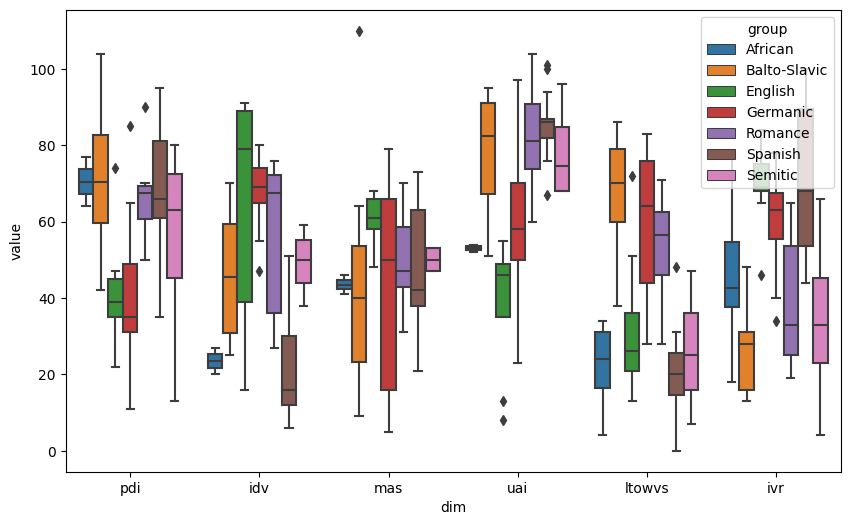

In [29]:
%matplotlib inline
sns.boxplot(long_df, y='value', x='dim', hue='group', hue_order=lang_groups)

In [30]:
def show_dimension(frame, dim, group_list):
    dim_df = frame.query(f'dim == "{dim}"')

    fig, axes = plt.subplots(figsize=(8,6))
    offset = 0.1
    plotted = set()

    for idx, row in dim_df.iterrows():
        x = x_orig = group_list.index(row.group)
        y = row.value

        multiple = 1
        side = 1
        while (x, y) in plotted:
            x = x_orig + side*multiple*offset
            if side == -1:
                multiple += 1
            side *= -1

        plt.scatter(x, y, label=f'{row.country} ({y})', color=BLUE, marker='_')
        plotted.add((x, y))

    axes.set_xticks(range(len(group_list)), group_list)
    yticks = axes.get_yticks()
    ytick_min, ytick_max = min(yticks), max(yticks)
    axes.set_yticks(np.arange(ytick_min, ytick_max+10, 10))
    axes.set_title(f'{dim.upper()}')
    axes.grid(axis='x', linestyle=':')

    mplcursors.cursor(multiple=True).connect(
        "add", lambda sel: sel.annotation.set_text(sel.artist.get_label()))

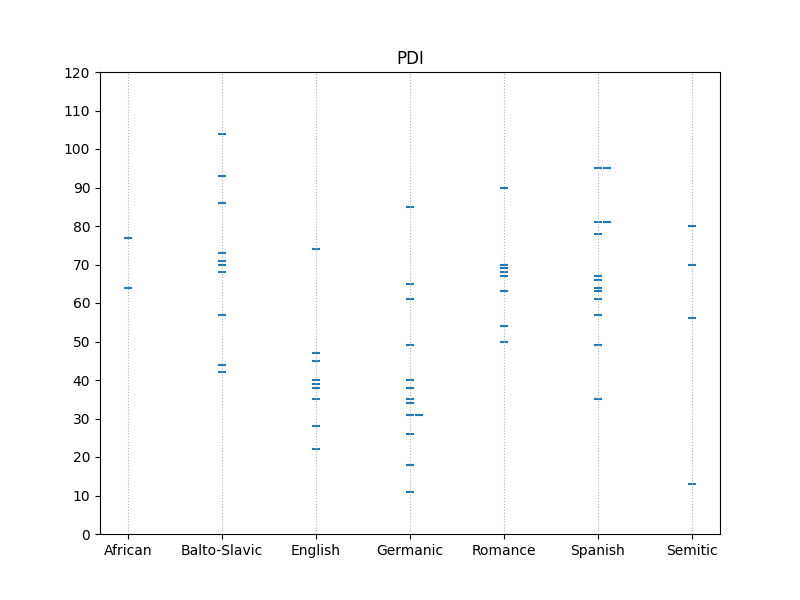

In [48]:
%matplotlib ipympl
show_dimension(long_df, 'pdi', group_list=lang_groups)

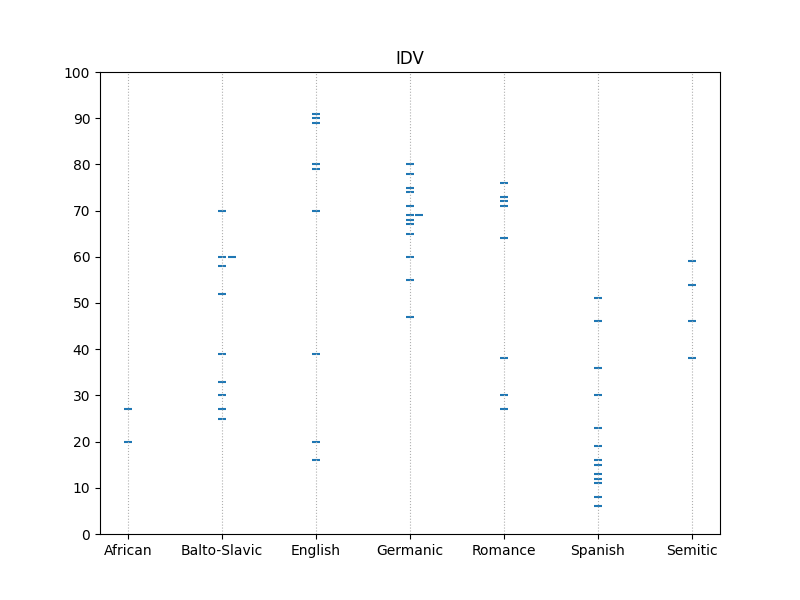

In [49]:
%matplotlib ipympl
show_dimension(long_df, 'idv', group_list=lang_groups)

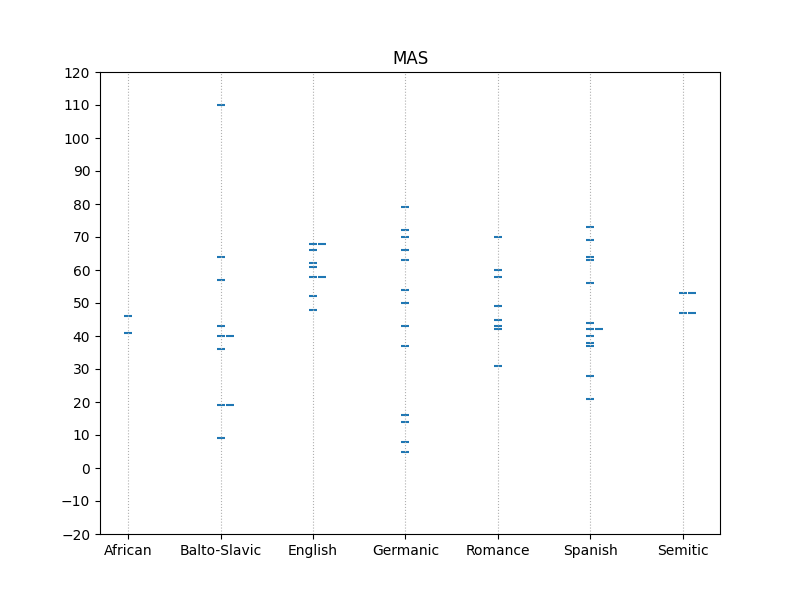

In [50]:
%matplotlib ipympl
show_dimension(long_df, 'mas', group_list=lang_groups)

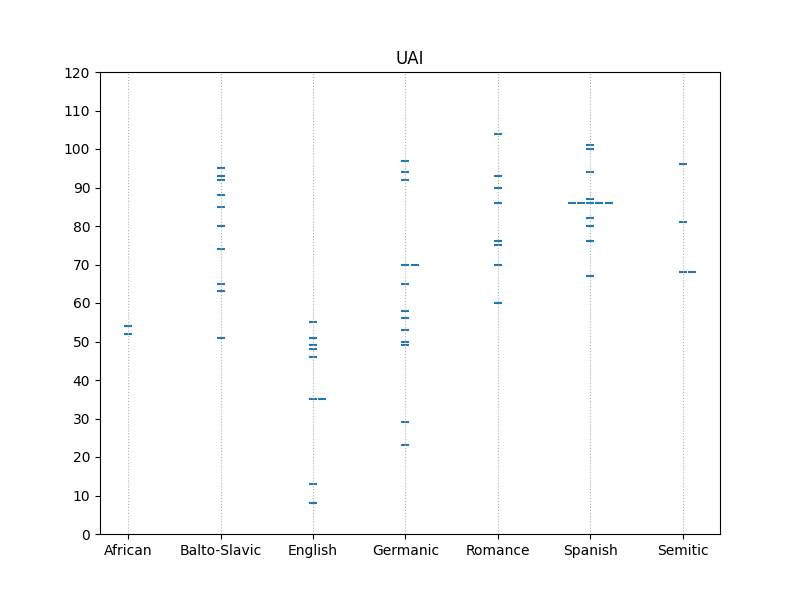

In [51]:
%matplotlib ipympl
show_dimension(long_df, 'uai', group_list=lang_groups)

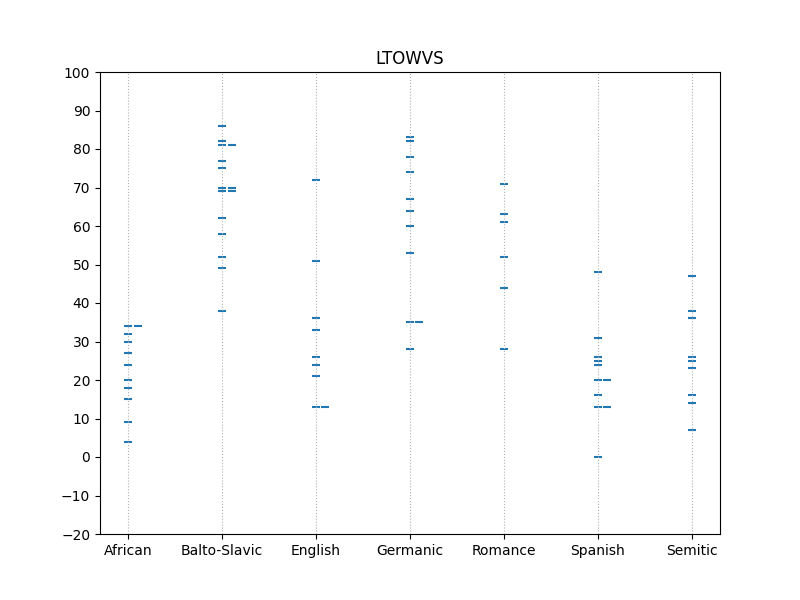

In [52]:
%matplotlib ipympl
show_dimension(long_df, 'ltowvs', group_list=lang_groups)

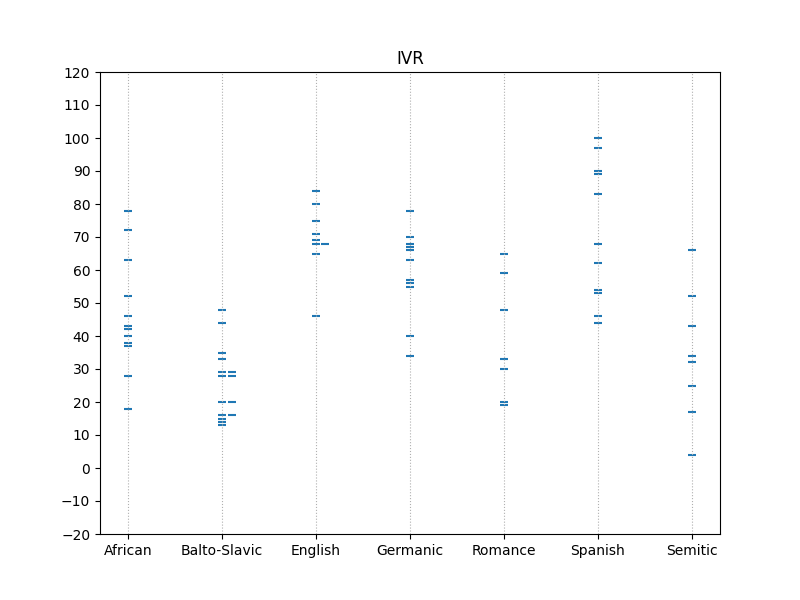

In [53]:
%matplotlib ipympl
show_dimension(long_df, 'ivr', group_list=lang_groups)

In [54]:
subset_df.sample(5).sort_index()

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr,group
19,CAN,Canada,39.0,80.0,52.0,48.0,36.0,68.0,English
49,IRQ,Iraq,NaN,NaN,NaN,NaN,25.0,17.0,Semitic
70,NOR,Norway,31.0,69.0,8.0,50.0,35.0,55.0,Germanic
92,SWF,Switzerland French,70.0,64.0,58.0,70.0,NaN,NaN,Romance
98,USA,United States,40.0,91.0,62.0,46.0,26.0,68.0,English


In [38]:
# Test mean differences
frames = [subset_df.loc[subset_df.group == g, DIMENSIONS] for g in lang_groups]

pvals_3d = []
for row_df in frames:
    pvals_2d = []
    for col_df in frames:
        pvals = stats.ttest_ind(row_df, col_df, equal_var=False, nan_policy='omit').pvalue
        pvals_2d.append(pvals)
    pvals_3d.append(pvals_2d)

In [39]:
cube = np.array(pvals_3d)
cube.shape

pvals_df_by_dim = {
    dim: pd.DataFrame(cube[:, :, idx], index=lang_groups, columns=lang_groups)
    for idx, dim in enumerate(DIMENSIONS)
}
pvals_df_by_dim.keys()

dict_keys(['pdi', 'idv', 'mas', 'uai', 'ltowvs', 'ivr'])

In [70]:
def heatmap(square, vmin=0, vmax=1):
    fig, ax = plt.subplots()
    mask = np.zeros_like(square)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(square, annot=True, mask=mask, vmin=vmin, vmax=vmax, ax=ax, square=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 25)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25)

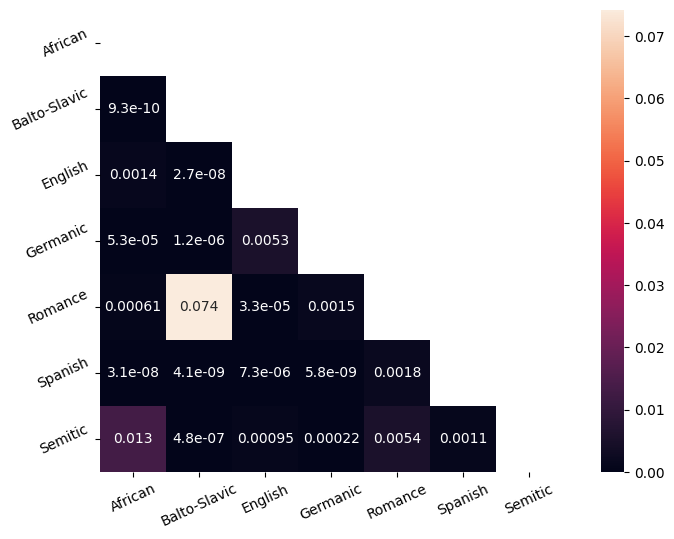

In [71]:
%matplotlib inline
heatmap(pd.DataFrame(cube.min(axis=2), index=lang_groups, columns=lang_groups), vmax=None)

In [42]:
# P-Values 
row_idx = lang_groups.index('Balto-Slavic')
col_idx = lang_groups.index('Romance')

pd.Series(cube[row_idx, col_idx, :], index=DIMENSIONS)
# cube[row_idx, col_idx, :]

pdi       0.57
idv       0.25
mas       0.56
uai       0.65
ltowvs    0.07
ivr       0.11
dtype: float64

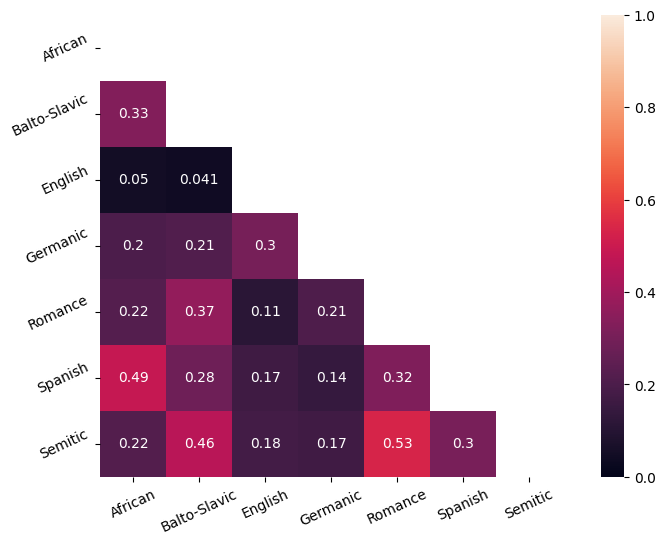

In [72]:
heatmap(pd.DataFrame(cube.mean(axis=2), index=lang_groups, columns=lang_groups))

In [44]:
mean_approximated = pd.concat([group.fillna(group.mean(numeric_only=True))
for name, group in subset_df.groupby('group')
])
mean_approximated.sample(5).sort_index()

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr,group
18,BUF,Burkina Faso,70.50,23.5,43.50,53.00,27.0,18.0,African
66,MOR,Morocco,70.00,46.0,53.00,68.00,14.0,25.0,Semitic
77,PUE,Puerto Rico,68.62,22.0,47.46,85.92,0.0,90.0,Spanish
100,UKR,Ukraine,70.80,45.4,43.70,78.60,86.0,14.0,Balto-Slavic
101,URU,Uruguay,61.00,36.0,38.00,100.00,26.0,53.0,Spanish


In [45]:
features = mean_approximated.loc[:, DIMENSIONS]
target = mean_approximated.loc[:, 'group']

display(features.head(), target.head())

,pdi,idv,mas,uai,ltowvs,ivr
0,64.0,27.0,41.0,52.0,32.00,40.0
1,77.0,20.0,46.0,54.0,9.00,78.0
18,70.5,23.5,43.5,53.0,27.00,18.0
32,70.5,23.5,43.5,53.0,22.45,46.0
39,70.5,23.5,43.5,53.0,4.00,72.0


0     African
1     African
18    African
32    African
39    African
Name: group, dtype: object

In [46]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# X, y = load_iris(return_X_y=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(features, target)#.predict(X_test)
#print("Number of mislabeled points out of a total %d points : %d"
#...       % (X_test.shape[0], (y_test != y_pred).sum()))

GaussianNB()

In [90]:
from sklearn import metrics

assert((features.index == target.index).all())

misclassified = []
for idx in features.index:
    pred = gnb.predict(features.loc[[idx], :])[0]
    targ = target.loc[idx]

    if pred != targ:
        misclassified.append({
            'country': mean_approximated.loc[idx].country,
            'group': targ,
            'prediction': pred,
            **dict(zip(gnb.classes_, gnb.predict_proba(features.loc[[idx], :])[0])),
        })

mis_df = pd.DataFrame(misclassified)
display(mis_df)

print(mis_df.to_markdown())

,country,group,prediction,African,Balto-Slavic,English,Germanic,Romance,Semitic,Spanish
0,Bosnia and Herzegovina,Balto-Slavic,Romance,0.0,4.77e-01,2.17e-07,1.67e-03,0.52,1.04e-04,8.05e-07
1,Poland,Balto-Slavic,Romance,0.0,1.06e-01,1.28e-07,1.61e-03,0.89,2.64e-11,9.00e-04
2,Belgium Netherl,Germanic,Romance,0.0,4.88e-04,4.03e-06,3.42e-01,0.66,4.66e-11,2.48e-07
3,Suriname,Germanic,Romance,0.0,7.14e-02,2.56e-08,1.73e-02,0.91,9.82e-11,1.66e-03
4,Moldova,Romance,Balto-Slavic,0.0,7.75e-01,5.88e-11,4.73e-05,0.22,3.90e-03,2.51e-09
5,Portugal,Romance,Spanish,0.0,3.79e-02,1.29e-11,1.93e-07,0.13,3.54e-23,8.34e-01
6,Romania,Romance,Balto-Slavic,0.0,8.90e-01,1.92e-13,2.48e-09,0.11,2.70e-07,6.88e-04
7,Malta,Semitic,Romance,0.0,2.53e-04,1.92e-04,3.76e-01,0.59,2.56e-02,3.74e-03
8,Spain,Spanish,Romance,0.0,6.49e-02,1.08e-06,1.19e-02,0.92,7.57e-04,1.39e-03


|    | country                | group        | prediction   |   African |   Balto-Slavic |     English |    Germanic |   Romance |     Semitic |     Spanish |
|---:|:-----------------------|:-------------|:-------------|----------:|---------------:|------------:|------------:|----------:|------------:|------------:|
|  0 | Bosnia and Herzegovina | Balto-Slavic | Romance      |         0 |     0.476886   | 2.16668e-07 | 0.00166581  |  0.521342 | 0.000104342 | 8.04892e-07 |
|  1 | Poland                 | Balto-Slavic | Romance      |         0 |     0.10565    | 1.28415e-07 | 0.00161062  |  0.89184  | 2.63871e-11 | 0.000899772 |
|  2 | Belgium Netherl        | Germanic     | Romance      |         0 |     0.00048831 | 4.02681e-06 | 0.341792    |  0.657715 | 4.66233e-11 | 2.47791e-07 |
|  3 | Suriname               | Germanic     | Romance      |         0 |     0.0713807  | 2.56223e-08 | 0.0173279   |  0.909634 | 9.82076e-11 | 0.00165776  |
|  4 | Moldova                | Romance      |

In [92]:
preds = gnb.predict(features)

conf_mat = pd.DataFrame(metrics.confusion_matrix(preds, target), index=gnb.classes_, columns=gnb.classes_)
display(conf_mat)

print(conf_mat.to_markdown())
print(conf_mat.to_latex())

,African,Balto-Slavic,English,Germanic,Romance,Semitic,Spanish
African,12,0,0,0,0,0,0
Balto-Slavic,0,13,0,0,2,0,0
English,0,0,10,0,0,0,0
Germanic,0,0,0,13,0,0,0
Romance,0,2,0,2,7,1,1
Semitic,0,0,0,0,0,8,0
Spanish,0,0,0,0,1,0,14


|              |   African |   Balto-Slavic |   English |   Germanic |   Romance |   Semitic |   Spanish |
|:-------------|----------:|---------------:|----------:|-----------:|----------:|----------:|----------:|
| African      |        12 |              0 |         0 |          0 |         0 |         0 |         0 |
| Balto-Slavic |         0 |             13 |         0 |          0 |         2 |         0 |         0 |
| English      |         0 |              0 |        10 |          0 |         0 |         0 |         0 |
| Germanic     |         0 |              0 |         0 |         13 |         0 |         0 |         0 |
| Romance      |         0 |              2 |         0 |          2 |         7 |         1 |         1 |
| Semitic      |         0 |              0 |         0 |          0 |         0 |         8 |         0 |
| Spanish      |         0 |              0 |         0 |          0 |         1 |         0 |        14 |
\begin{tabular}{lrrrrrrr}
\toprule
{}

/tmp/ipykernel_19788/1230011796.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(conf_mat.to_latex())


In [75]:
metrics.matthews_corrcoef(preds, target)

0.878215350728337

In [76]:
# mean accuracy
gnb.score(features, target)

0.8953488372093024

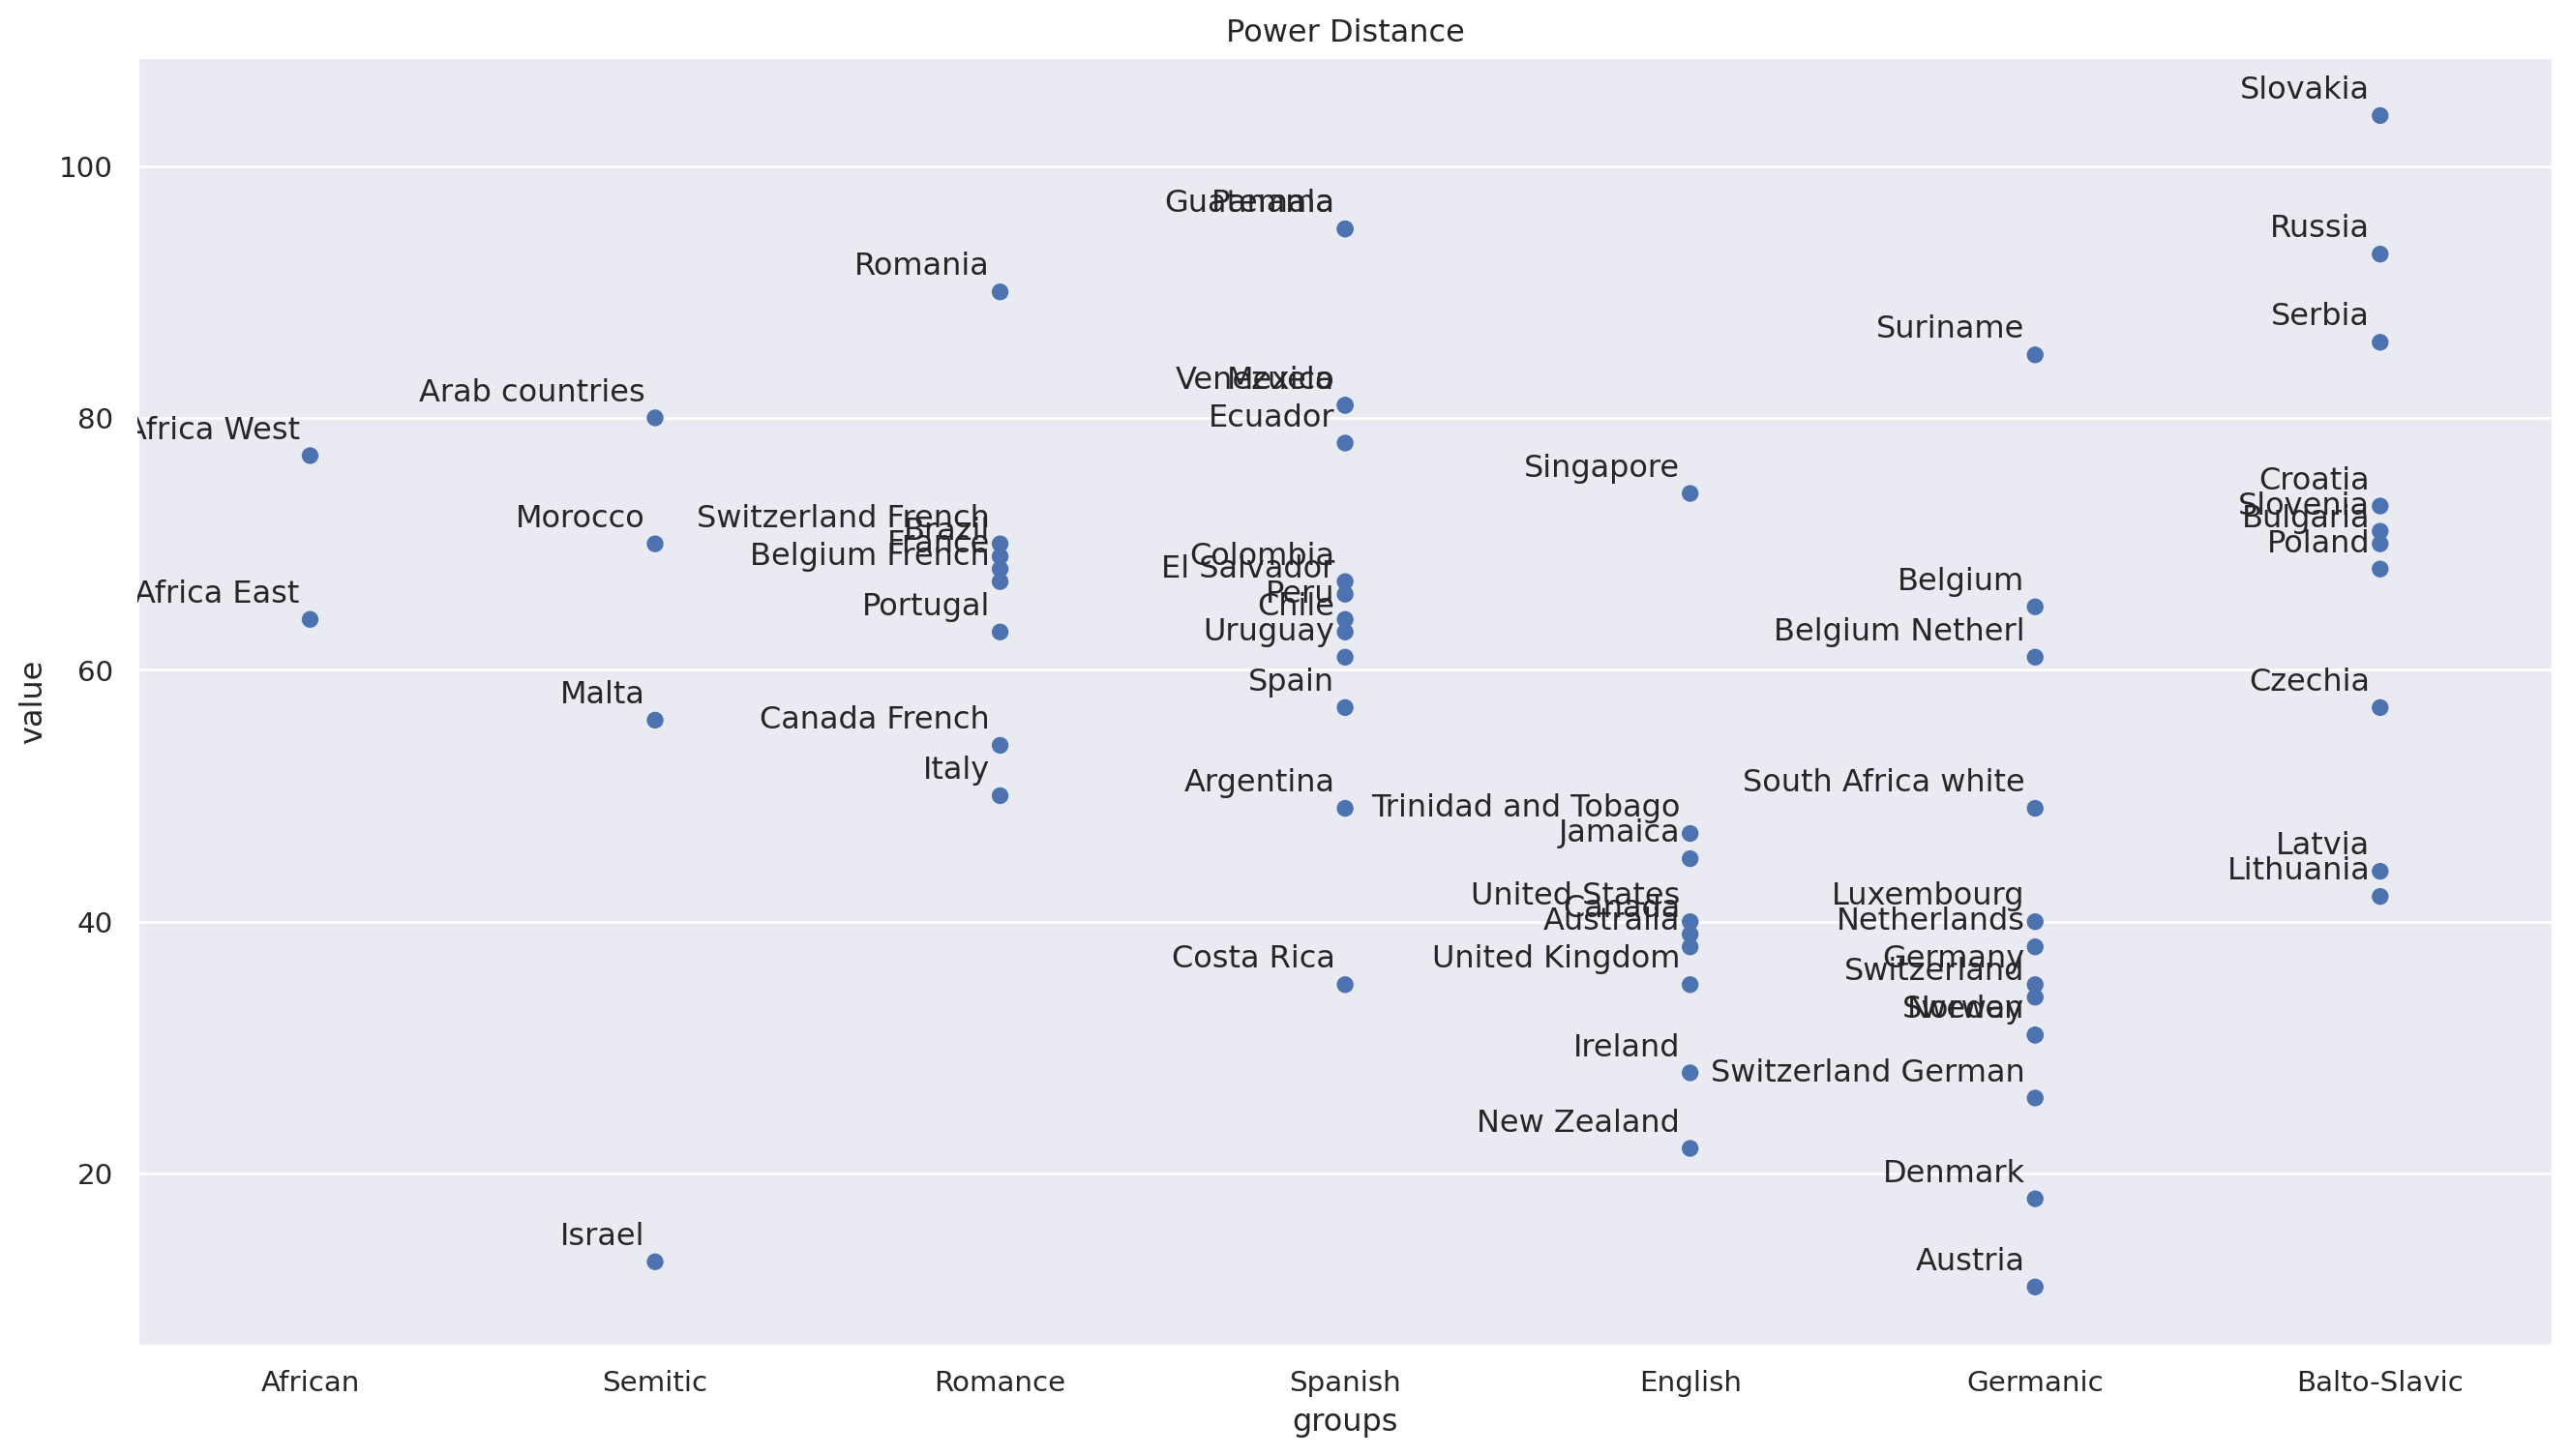

In [81]:
import seaborn.objects as so
(
    so.Plot(long_df.query('dim == "pdi"'), x="group", y="value", text='country')
        .add(so.Dot())
        .add(so.Text(halign="right", valign='bottom'))
        .label(title='Power Distance', x="groups", y='value')
        .layout(size=(14, 8))
)

In [82]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = 1

estimator = KNeighborsClassifier(n_neighbors=n_neighbors)
estimator.fit(features, target)

KNeighborsClassifier(n_neighbors=1)

In [83]:
# Power-distance, Individualism, Masculinity, Uncertainty-avoidance, Long-term Orientation, Indulgence

estimator.predict([[60, 60, 70, 40, 90, 30]]) # Germany
estimator.predict([[50, 50, 100, 0, 100, 0]]) # Chinese
estimator.predict([[50, 50, 50, 50, 100, 0]]) # Russian

/home/jarda/Desktop/sep/venv/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/jarda/Desktop/sep/venv/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/jarda/Desktop/sep/venv/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['Balto-Slavic'], dtype=object)

In [ ]:
from sklearn.model_selection import LeaveOneOut
import tqdm

estimator = KNeighborsClassifier(n_neighbors=n_neighbors)

estimated = []

train_test_gen = LeaveOneOut().split(features)
for train_index, test_index in tqdm.tqdm(train_test_gen):
    estimator.fit(features[train_index], target[train_index])
    estimated.append(
        [target[test_index][0], estimator.predict(features[test_index])[0]]
    )

72it [00:00, 614.06it/s]


In [ ]:
estimated

[['African', 'Thai'],
 ['African', 'English'],
 ['Arabic', 'Arabic'],
 ['Spanish', 'Spanish'],
 ['English', 'English'],
 ['German', 'German'],
 ['Indo-Iranian', 'Malayo-Polynesian'],
 ['West Germanic', 'French'],
 ['French', 'West Germanic'],
 ['Portuguese', 'Turkish'],
 ['South Slavic', 'South Slavic'],
 ['English', 'French'],
 ['French', 'English'],
 ['Spanish', 'Spanish'],
 ['Sinitic', 'Sinitic'],
 ['Spanish', 'Spanish'],
 ['South Slavic', 'South Slavic'],
 ['West Slavic', 'Romance'],
 ['North Germanic', 'North Germanic'],
 ['Spanish', 'Spanish'],
 ['Finno-Ugric', 'Russian'],
 ['Russian', 'Finno-Ugric'],
 ['Finno-Ugric', 'North Germanic'],
 ['French', 'French'],
 ['German', 'German'],
 ['English', 'English'],
 ['Greek', 'Spanish'],
 ['Sinitic', 'Vietnamese'],
 ['Finno-Ugric', 'Romance'],
 ['Indo-Iranian', 'Sinitic'],
 ['Malayo-Polynesian', 'Vietnamese'],
 ['Indo-Iranian', 'Arabic'],
 ['English', 'English'],
 ['Romance', 'Finno-Ugric'],
 ['Japanese', 'Finno-Ugric'],
 ['Korean', 'Sini

ConversionError: Failed to convert value(s) to axis units: ['Portuguese', 'English', 'Vietnamese', 'Indo-Iranian', 'North Germanic', 'Korean', 'Turkish', 'Spanish', 'Thai', 'Finno-Ugric', 'Japanese', 'Russian', 'South Slavic', 'French', 'African', 'West Germanic', 'West Slavic', 'Sinitic', 'Greek', 'Romance', 'Arabic', 'Balto-Slavic', 'Malayo-Polynesian', 'German']

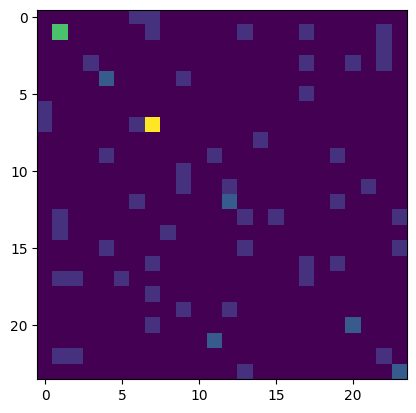

In [ ]:

labels=list(set(target))
conf_mat = confusion_matrix(*zip(*estimated), labels=labels)

ax = plt.imshow(conf_mat, cmap='hot')
plt.xticks(labels)
conf_mat

In [ ]:
correct = np.diag(conf_mat).sum()
wrong = conf_mat[~np.eye(conf_mat.shape[0], dtype=bool)].sum()
accuracy = correct / (correct + wrong)
accuracy

expected_random = 1 / conf_mat.shape[0]
expected_random

0.041666666666666664

In [31]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(estimator, features, target, cv=len(target)))

ValueError: n_splits=72 cannot be greater than the number of members in each class.